In [4]:
#  you may need to install these packages first by running these install commands
#install.packages("zipcode", repos = "http://cran.us.r-project.org")
#install.packages("ggmap", repos = "http://cran.us.r-project.org")
#install.packages("plyr", repos = "http://cran.us.r-project.org")
#install.packages("effsize", repos = "http://cran.us.r-project.org")
#install.packages("ggthemes", repos = "http://cran.us.r-project.org")
#install.packages("deldir", repos = "http://cran.us.r-project.org")
#install.packages("ggplot2", repos = "http://cran.us.r-project.org")
#install.packages("tictoc", repos = "http://cran.us.r-project.org")

library(ggplot2)
library(zipcode)
library(plyr)
library(effsize)
library(tictoc)

In [5]:
print("hello")

[1] "hello"


In [6]:
trips = read.csv("../data/sample_100000.csv")
str(trips)

'data.frame':	99999 obs. of  18 variables:
 $ VendorID             : int  2 1 1 1 1 2 1 2 2 2 ...
 $ tpep_pickup_datetime : Factor w/ 17958 levels "2015-01-01 00:00:00",..: 6044 6044 6045 6045 6047 6047 6047 6048 6049 6049 ...
 $ tpep_dropoff_datetime: Factor w/ 19975 levels "2015-01-01 00:00:00",..: 7582 7601 7838 8000 7411 7467 7616 7413 7816 8063 ...
 $ passenger_count      : int  1 3 1 1 1 1 1 1 3 1 ...
 $ trip_distance        : num  1.55 1.2 2.4 7.3 0.4 0.71 1.6 0.52 6.23 5.88 ...
 $ pickup_longitude     : num  -74 -74 -74 -74 -74 ...
 $ pickup_latitude      : num  40.7 40.7 40.8 40.7 40.8 ...
 $ RateCodeID           : int  1 1 1 1 1 1 1 1 1 5 ...
 $ store_and_fwd_flag   : Factor w/ 2 levels "N","Y": 1 1 1 1 1 1 1 1 1 1 ...
 $ dropoff_longitude    : num  -74 -74 -74 -73.9 -74 ...
 $ dropoff_latitude     : num  40.7 40.7 40.8 40.8 40.8 ...
 $ payment_type         : int  2 2 2 2 2 2 1 1 1 1 ...
 $ fare_amount          : num  7.5 7 10.5 21.5 3.5 5 7.5 4 18.5 75 ...
 $ extra          

In [7]:
prepare_data <- function(trips){
        # convert dates into datetime format (POSIXct) to be able to process them conveniently
        trips <- castDatetimesToLT(trips)
        # vendor id could be 1 - Creative Mobile Technologies or 2 - Verifone, so it is a factor variable
        trips$vendor_id <- as.factor(trips$VendorID)
        # rate code is a factor variable (1= Standard rate, 2=JFK, 3=Newark, 4=Nassau or Westchester 5=Negotiated fare 6=Group ride)
        trips$rate_code <- as.factor(trips$RateCodeID)
        # payment type is a factor variable (1= Credit card, 2= Cash, 3= No charge, 4= Dispute, 5= Unknown 6= Voided trip)
        trips$payment_type <- as.factor(trips$payment_type)
        #add tip percentages
        trips$tip_percentage <- 100*(trips$tip_amount / (trips$total_amount - trips$tip_amount))

        trips
}
castDatetimesToLT <- function(trips){
        trips$tpep_pickup_datetime <- as.POSIXlt(as.character(trips$tpep_pickup_datetime,format="%Y-%m-%dT%H:%M:%OS"), "EST")
        trips$tpep_dropoff_datetime <- as.POSIXlt(as.character(trips$tpep_dropoff_datetime,format="%Y-%m-%dT%H:%M:%OS"), "EST")

        trips
}
castDatetimesToCT <- function(trips){
        trips$tpep_pickup_datetime <- as.POSIXct(trips$tpep_pickup_datetime)
        trips$tpep_dropoff_datetime <- as.POSIXct(trips$tpep_dropoff_datetime)

        trips
}

clean_data <- function(trips){
        #NYC_coordinates <- geocode("Manhattan New York")
        #NYC_region <- c(NYC_coordinates["lat"]-1,NYC_coordinates["lat"]+1,NYC_coordinates["lon"]-1,NYC_coordinates["lon"]+1)
        NYC_region <- c(-74.15,40.5,-73.65,41)
        # remove records with longitudes which is not NYC (the limits are taken by hand looking at NYC Google Map)
        trips <- trips[trips$pickup_longitude > NYC_region[1],]
        trips <- trips[trips$pickup_longitude < NYC_region[3],]
        # remove records with Latitudes which is not NYC (the limits are taken by hand looking at NYC Google Map)
        trips <- trips[trips$dropoff_latitude > NYC_region[2],]
        trips <- trips[trips$dropoff_latitude < NYC_region[4],]
        # remove all trips where payment was done not via credit card, as only then we have the info about tips
        trips <- trips[trips$payment_type == 1,]
        # remove all trips where tip amount is 0 or negative (as we are interested in very high tips)
        trips <- trips[trips$tip_amount > 0,]
        # remove all trips where passenger count is 0
        trips <- trips[trips$passenger_count > 0,]

        trips
}

augment_data <- function(trips){
        # augment data with the closest ZIPCODES
        data(zipcode)
        # collect a dataset with zipcodes from New York state
        NYCzips <- subset(zipcode, state== "NY")
        # we need to cast first datetimes first to another format to make sure we do not face problems with apply method
        trips_ct <- castDatetimesToCT(trips)
        # for each record in our trips dataset find a nearest ZIP code
        trips$zipcode <- apply(trips_ct, 1, function(x){getZipCode(NYCzips,x['pickup_longitude'],x['pickup_latitude'],0.2)})
        # make the zipcode column a categorical variable
        trips$zipcode <- as.factor(trips$zipcode)

        trips
}

getZipCode <- function(zips, lon, lat, step){
        lat <- as.numeric(lat)
        lon <- as.numeric(lon)
        step <- as.numeric(step)
        # define borders in which to search for nearest ZIP codes
        area_borders <- c(lat-step, lat+step, lon-step, lon+step)
        # filter the zip codes fitting the borders
        local_zips <- zips[zips$latitude > area_borders[1] && zips$latitude< area_borders[2] && zips$longitude > area_borders[3] && zips$longitude < area_borders[4],]

        if (nrow(local_zips) == 0){
                if (step < 2){
                        # if there are no ZIP codes in the borders, enlarge the borders and recursively repeat the operation
                        r <- getZipCode(zips, lon, lat, step+0.2)
                }else{
                        # if step is already too big - just return NA
                        r <- as.character("000000")
                }
        }else{
                # calculate the distances to the ZIP codes filtered
                local_zips$distance = sqrt((local_zips$latitude-lat)^2 + (local_zips$longitude-lon)^2)
                # sort the filtered ZIP codes according to the distance
                local_zips = local_zips[order(local_zips$distance),]
                # return the nearest ZIP code
                r <- as.character(local_zips[1,"zip"])
        }

        r
}

group_data <- function(trips){
        # we need to cast first datetimes first to another format to make sure we do not face problems with apply method
        trips_ct <- castDatetimesToCT(trips)
        # a workaround to calculate amount of records for each ZIP code
        trips_ct$row_weight <- as.numeric(1)

        # make a new dataset 'zones' by aggregating trips by ZIP codes
        zones <- ddply(trips_ct, "zipcode", summarise,
                lat = median(pickup_latitude),
                lon = median(pickup_longitude),
                amount = sum(row_weight),
                tip_percentage.mean=mean(tip_percentage),
                tip_percentage.median=median(tip_percentage),
                tip_amount.mean=mean(tip_amount),
                tip_amount.median=median(tip_amount)
                )

        # prepare and format columns

        zones$tip_amount.mean_round <- round(zones$tip_amount.mean)
        zones$tip_amount.mean_round <- as.factor(paste(zones$tip_amount.mean_round,"$",sep=""))

        zones$tip_amount.median_round <- round(zones$tip_amount.median)
        zones$tip_amount.median_round <- as.factor(paste(zones$tip_amount.median_round,"$",sep=""))

        zones$tip_percentage.median_round <- round(zones$tip_percentage.median)
        zones$tip_percentage.median_round <- as.factor(paste(zones$tip_percentage.median_round,"%",sep=""))

        zones$tip_percentage.mean_round <- round(zones$tip_percentage.mean)
        zones$tip_percentage.mean_round <- as.factor(paste(zones$tip_percentage.mean_round,"%",sep=""))
        # remove not representative zones
        #zones<- zones[zones$amount > 500,]

        zones
}




In [8]:
trips_prepared <- prepare_data(trips)
str(trips_prepared)

'data.frame':	99999 obs. of  21 variables:
 $ VendorID             : int  2 1 1 1 1 2 1 2 2 2 ...
 $ tpep_pickup_datetime : POSIXlt, format: "2015-01-08 22:44:09" "2015-01-08 22:44:09" ...
 $ tpep_dropoff_datetime: POSIXlt, format: "2015-01-08 22:50:56" "2015-01-08 22:51:17" ...
 $ passenger_count      : int  1 3 1 1 1 1 1 1 3 1 ...
 $ trip_distance        : num  1.55 1.2 2.4 7.3 0.4 0.71 1.6 0.52 6.23 5.88 ...
 $ pickup_longitude     : num  -74 -74 -74 -74 -74 ...
 $ pickup_latitude      : num  40.7 40.7 40.8 40.7 40.8 ...
 $ RateCodeID           : int  1 1 1 1 1 1 1 1 1 5 ...
 $ store_and_fwd_flag   : Factor w/ 2 levels "N","Y": 1 1 1 1 1 1 1 1 1 1 ...
 $ dropoff_longitude    : num  -74 -74 -74 -73.9 -74 ...
 $ dropoff_latitude     : num  40.7 40.7 40.8 40.8 40.8 ...
 $ payment_type         : Factor w/ 4 levels "1","2","3","4": 2 2 2 2 2 2 1 1 1 1 ...
 $ fare_amount          : num  7.5 7 10.5 21.5 3.5 5 7.5 4 18.5 75 ...
 $ extra                : num  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 

In [9]:
trips_cleaned <- clean_data(trips_prepared)
str(trips_cleaned)

'data.frame':	54466 obs. of  21 variables:
 $ VendorID             : int  1 2 2 2 2 1 2 2 1 2 ...
 $ tpep_pickup_datetime : POSIXlt, format: "2015-01-08 22:44:12" "2015-01-08 22:44:13" ...
 $ tpep_dropoff_datetime: POSIXlt, format: "2015-01-08 22:51:35" "2015-01-08 22:46:37" ...
 $ passenger_count      : int  1 1 3 1 1 1 1 1 2 3 ...
 $ trip_distance        : num  1.6 0.52 6.23 5.88 3.48 1 4.85 1.11 1.6 1.17 ...
 $ pickup_longitude     : num  -74 -74 -74 -73.9 -74 ...
 $ pickup_latitude      : num  40.8 40.8 40.7 40.7 40.8 ...
 $ RateCodeID           : int  1 1 1 5 1 1 1 1 1 1 ...
 $ store_and_fwd_flag   : Factor w/ 2 levels "N","Y": 1 1 1 1 1 1 1 1 1 1 ...
 $ dropoff_longitude    : num  -74 -74 -74 -73.9 -74 ...
 $ dropoff_latitude     : num  40.7 40.8 40.8 40.7 40.7 ...
 $ payment_type         : Factor w/ 4 levels "1","2","3","4": 1 1 1 1 1 1 1 1 1 1 ...
 $ fare_amount          : num  7.5 4 18.5 75 15 5 19.5 6 9 5.5 ...
 $ extra                : num  0.5 0.5 0.5 0 0.5 0.5 0.5 0.5 0.5 

In [10]:
#install.packages("tictoc")
library(tictoc)
tic()
ddply(trips_cleaned, .(payment_type), summarize,  Rate1=mean(tip_amount))
toc()

payment_type,Rate1
1,2.81993


0.133 sec elapsed


In [11]:
quantile(trips_cleaned$tip_percentage,c(0.95,0.99,0.999))

95%       99%     99.9% 
 29.41176  41.66667 128.20513

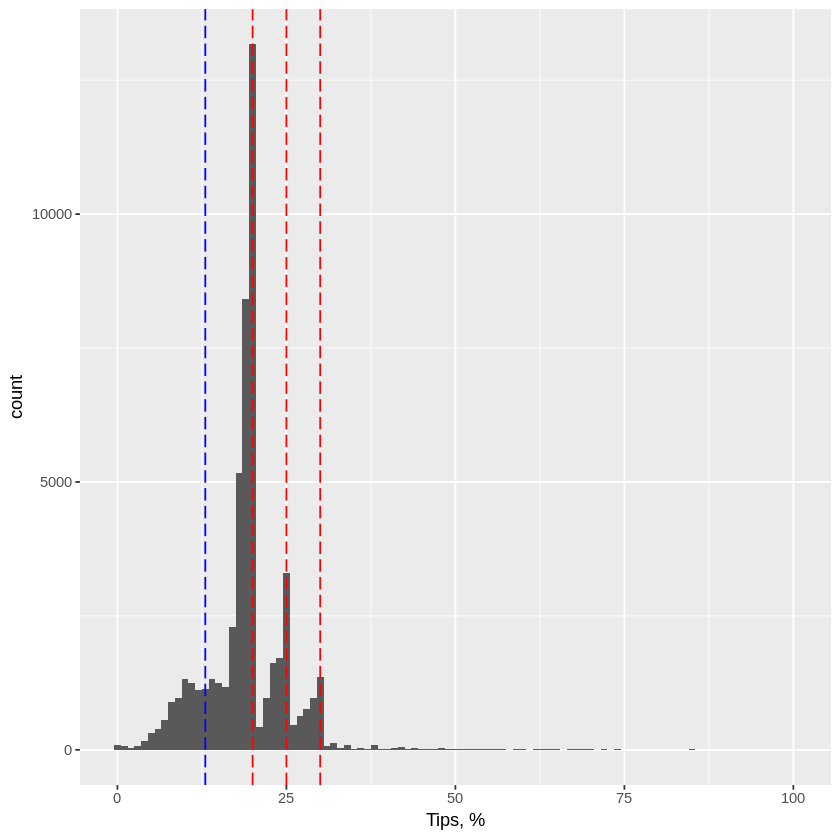

In [12]:
trips_cleaned <- trips_cleaned[trips_cleaned$tip_percentage<=100,]
ggplot(data = trips_cleaned, aes(x = tip_percentage))+xlab("Tips, %") + geom_histogram(binwidth = 1) + geom_vline(xintercept = c(20,25,30), col = "red",linetype = "longdash") + geom_vline(xintercept = c(13), col = "blue",linetype = "longdash")

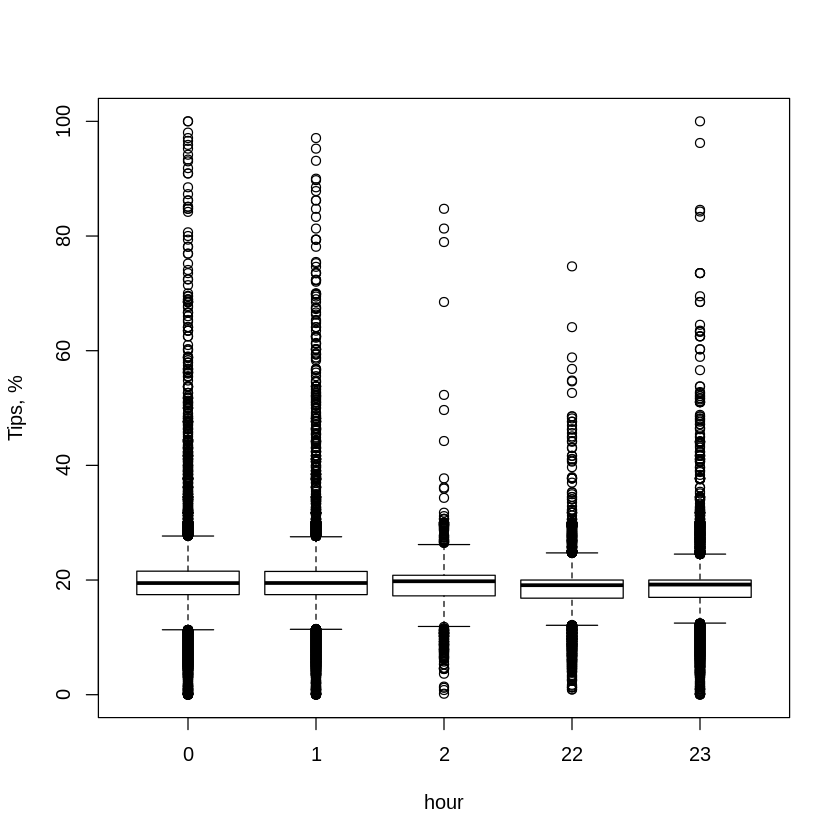

In [13]:
plot(as.factor(trips_cleaned$tpep_pickup_datetime$hour), trips_cleaned$tip_percentage, xlab = "hour", ylab="Tips, %")

In [ ]:
trips_short_zip <- augment_data(trips_cleaned)
zones <- group_data(trips_short_zip)
str(zones)

In [ ]:
zones <- zones[zones$amount >500,]

WorldTradeCenter_10250 <- trips_short_zip[trips_short_zip$zipcode == "10250",]  
LaGuardia_11371 <- trips_short_zip[trips_short_zip$zipcode == "11371",]
TimesSquare_10036 <- trips_short_zip[trips_short_zip$zipcode == "10036",]
JFK_11430 <- trips_short_zip[trips_short_zip$zipcode == "11430",]

welch_test <- t.test(TimesSquare_10036$tip_percentage,WorldTradeCenter_10250$tip_percentage,alternative = "greater")
welch_test$p.value

In [ ]:
cohen_distance <- cohen.d(TimesSquare_10036$tip_percentage,WorldTradeCenter_10250$tip_percentage)
cohen_distance$estimate

In [ ]:
welch_test <- t.test(LaGuardia_11371$tip_percentage,JFK_11430$tip_percentage,alternative = "greater")
welch_test$p.value

In [ ]:
cohen_distance <- cohen.d(LaGuardia_11371$tip_percentage,JFK_11430$tip_percentage)
cohen_distance$estimate